# Gift Recommender Engine: Twitter Data Analysis

Before I test on real tweet data extracted using Twitter's API, I want to develop and evaluate a tweet processing approach. To do this, I will use a dataset found in [Kaggle](https://www.kaggle.com/kazanova/sentiment140) that contains over 1.6 million tweets labelled as negative or positive. I will test different sentiment analysis and topic modelling approaches on this dataset, while also devising a strategy to make my classifier more "compatible" with tweets and further evaluate my classifier.

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk 
import string
import spacy
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_style('ticks')

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacytextblob.spacytextblob import SpacyTextBlob

In [141]:
encoding = "ISO-8859-1"
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('datasets/training.1600000.processed.noemoticon.csv', encoding=encoding, names=columns) 

In [142]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [143]:
print(df.shape)
df.isna().sum()

(1600000, 6)


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

## Exploratory Data Analysis

In [ ]:
I will perform some EDA to better understand thi

<b> How many positive and negative tweets are in the dataset? </b>

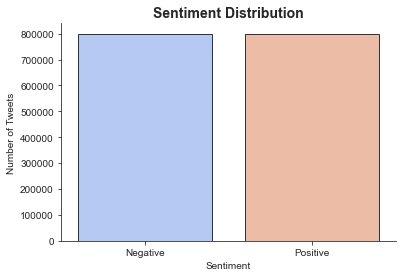

In [144]:
df_size = df.groupby('target').size().reset_index().rename(columns={0:'size'})
df_size['target'] = df_size['target'].apply(lambda x: 'Negative' if x == 0 else 'Positive')

sns.barplot(x=df_size['target'], y=df_size['size'], edgecolor='.2', palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
sns.despine()

<b> Are there any duplicated tweets? How many unique users are there? </b>

In [145]:
id_size = df.groupby('ids').size().reset_index().rename(columns={0:'size'})

In [146]:
duplicated_ids = id_size[id_size['size'] == 2]['ids'].to_list()
duplicated_df = df[df.ids.isin(duplicated_ids)][['ids', 'target', 'text']].sort_values('ids')
duplicated_df.head(10)

,ids,target,text
213,1467863684,0,Awwh babs... you look so sad underneith that s...
800261,1467863684,4,Awwh babs... you look so sad underneith that s...
275,1467880442,0,Haven't tweeted nearly all day Posted my webs...
800300,1467880442,4,Haven't tweeted nearly all day Posted my webs...
989,1468053611,0,@hellobebe I also send some updates in plurk b...
801280,1468053611,4,@hellobebe I also send some updates in plurk b...
1177,1468100580,0,good night swetdreamss to everyonee and jare...
801573,1468100580,4,good night swetdreamss to everyonee and jare...
1254,1468115720,0,@ientje89 aw i'm fine too thanks! yeah i miss ...
801650,1468115720,4,@ientje89 aw i'm fine too thanks! yeah i miss ...


It appears that the tweets belonging to the duplicated ids are classified as both positive and negative. This may mean that these tweets are neutral, but because this is such a small subset of the entire dataset and to avoid confusion, I will drop these tweets.

In [147]:
df = df[~df.ids.isin(duplicated_ids)]
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [148]:
num_users = df.groupby('user').size().reset_index().rename(columns={0: 'num_tweets'})
print('Total number of users: ', len(num_users))
print('Average number of tweets per user: ', round(num_users['num_tweets'].mean()))
num_users['num_tweets'].describe().reset_index().rename(columns={'index': 'metric', 'num_tweets': 'result'})

Total number of users:  659502
Average number of tweets per user:  2


,metric,result
0,count,659502.000000
1,mean,2.420963
2,std,4.697115
3,min,1.000000
4,25%,1.000000
5,50%,1.000000
6,75%,2.000000
7,max,549.000000


In [149]:
print("Number of users who have Tweeted more than 50 times: ", len(num_users[num_users.num_tweets >= 50]))

Number of users who have Tweeted more than 50 times:  919


Interesting; there are close to 1,600,000 unique tweets in this dataset but there are only 659,502 users. There are 919 users who have tweeted more than 50 times. I think I will extract 150 users who has tweeted more than 50 times and try to determine their interest from their tweets using my topic classifer which can be used as an evaluation tool.

In [150]:
many_tweets = num_users[num_users.num_tweets >= 50]['user'].to_list()
random.shuffle(many_tweets)
random_users = many_tweets[:150]

In [151]:
validate_df = df[df.user.isin(random_users)]
df = df[~df.user.isin(random_users)]

In [500]:
df.to_csv('datasets/kaggle-tweets.csv')

In [155]:
validate_df.to_csv('datasets/kaggle-tweets-users150.csv')

<b> What is the approximate length of each tweet? </b>

In [162]:
print('Average Tweet Length: {} words'.format(round(df.text.apply(lambda x: len(x.split())).mean())))

Average Tweet Length: 13 words


<b> Final checks! </b>

Let's check if the distribution of our dataset is still balanced!

In [157]:
df.groupby('target').size()

target
0    793821
4    791115
dtype: int64

It's still balanced! We can start to do some data cleaning before we experiment with sentiment analysis and topic modelling approaches.

## Sentiment Analysis

In [331]:
sa_df = df[['target', 'text']]

### Vader Sentiment Analysis - Before Preprocessing

In [332]:
analyzer = SentimentIntensityAnalyzer()
sa_df['vader_results'] = sa_df['text'].apply(lambda x: analyzer.polarity_scores(x))

In [508]:
sa_df['vader_negative'] = sa_df['vader_results'].apply(lambda x: x['neg'])
sa_df['vader_neutral'] = sa_df['vader_results'].apply(lambda x: x['neu'])
sa_df['vader_positive'] = sa_df['vader_results'].apply(lambda x: x['pos'])

In [319]:
#sa_df.to_csv('datasets/sentiment-analysis-kaggle.csv')

In [3]:
sa_df = pd.read_csv('datasets/sentiment-analysis-kaggle.csv')
sa_df.drop('Unnamed: 0', axis=1, inplace=True)

In [99]:
sa_df['vader_compound'] = sa_df['vader_results'].apply(lambda x: ast.literal_eval(x)['compound'])

In [100]:
sa_df.head()

,target,text,vader_results,vader_negative,vader_neutral,vader_positive,vader_compound
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'neg': 0.117, 'neu': 0.768, 'pos': 0.114, 'co...",0.117,0.768,0.114,-0.0173
1,0,is upset that he can't update his Facebook by ...,"{'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'comp...",0.291,0.709,0.000,-0.7500
2,0,@Kenichan I dived many times for the ball. Man...,"{'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'comp...",0.000,0.842,0.158,0.4939
3,0,my whole body feels itchy and like its on fire,"{'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp...",0.321,0.500,0.179,-0.2500
4,0,"@nationwideclass no, it's not behaving at all....","{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",0.138,0.862,0.000,-0.4939


<b> What is the distribution of positive, neutral, and negative tweets? </b>

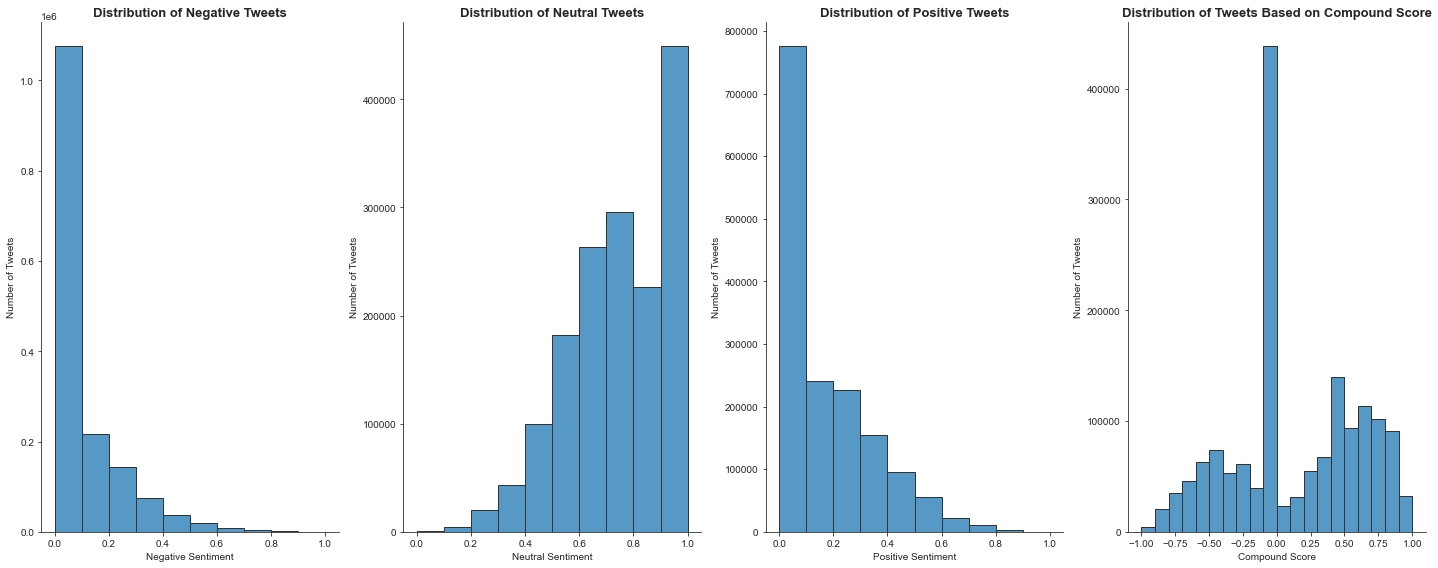

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))

sns.histplot(sa_df['vader_negative'], bins=10, edgecolor='.2', palette='coolwarm', ax=ax[0])
ax[0].set(xlabel="Negative Sentiment", ylabel="Number of Tweets")
ax[0].set_title("Distribution of Negative Tweets", fontsize=13, fontweight='bold')

sns.histplot(sa_df['vader_neutral'], bins=10, edgecolor='.2', palette='coolwarm', ax=ax[1])
ax[1].set(xlabel='Neutral Sentiment', ylabel='Number of Tweets')
ax[1].set_title("Distribution of Neutral Tweets", fontsize=13, fontweight='bold')

sns.histplot(sa_df['vader_positive'], bins=10, edgecolor='.2', palette='coolwarm', ax=ax[2])
ax[2].set(xlabel='Positive Sentiment', ylabel='Number of Tweets')
ax[2].set_title("Distribution of Positive Tweets", fontsize=13, fontweight='bold')

sns.histplot(sa_df['vader_compound'], bins=20, edgecolor='.2', palette='coolwarm', ax=ax[3])
ax[3].set(xlabel='Compound Score', ylabel='Number of Tweets')
ax[3].set_title('Distribution of Tweets Based on Compound Score', fontsize=13, fontweight='bold')

plt.tight_layout()
sns.despine()
plt.show()

Looking at the general benchmarks for Vader Sentiment Analysis, a compound score greater than 0.3 can be considered positive, a compound score between -0.3 and 0.3 can be considered neutral, and below that can be considered negative. To filter out what the user really likes, I will try to filter out a user's tweets based on the following categories:

1. <b>Trial 1</b>: Compound score greater than or equal to 0.6 (very positive tweets)
2. <b> Trial 2</b>: Compound score greater than or equal to 0.4 (positive tweets)
3. <b> Trial 3 </b>: Sort tweets based on compound score and take the top 30 tweets with the greatest sentiment.

I will test trial 1 and trial 2 first.

In [16]:
sa_df = pd.read_csv('datasets/sentiment-analysis-kaggle.csv')
sa_df.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
ext_pos_tweets = sa_df[(sa_df.vader_compound >= 0.6)]
pos_tweets = sa_df[sa_df.vader_compound >= 0.4]

## Test Positive Tweets Using Naive Bayes Model and Support Vector Classifier: Qualitative Check

### Data Cleaning Functions

In [18]:
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

punctuations = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    text = text.split() #split into list
    text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    text = [s.lower() for s in text] #convert every character into lowercase
    text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    return text

### Import Models using Pickle

In [6]:
# Naive Bayes Model
filename = open('models/nb_baseline1.sav', 'rb')
nb = pickle.load(filename)

In [7]:
# Support Vector Classifier Model
filename = open('models/linear_svc_baseline1.sav', 'rb')
ovr_svc = pickle.load(filename)

In [8]:
# Import Vectorizer

filename = open('models/tfidf_vectorizer.sav', 'rb')
tfidf = pickle.load(filename)

In [9]:
# Import Reference Dictionary

filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

In [37]:
ext_pos_tweets.shape

(332724, 7)

### Trial 1: Extremely Positive Tweets

Let's start off small. I'll randomly sample around 500 tweets from the extremely positive tweets and try to predict topic outcome from there. I'll compute the predicted class from the Naive Bayes model, the Support Vector Classifier model, as well as their reported probabilities.

In [49]:
ext_pos_small = ext_pos_tweets.sample(frac=1)[:3500]

In [50]:
ext_pos_small['clean-text'] = ext_pos_small['text'].map(preprocess).apply(lambda x: ' '.join(spacy_lemmatize(x)))

In [51]:
ext_pos_small['nb_topic_predict'] = ext_pos_small['clean-text'].apply(lambda x: ref[nb.predict(tfidf.transform([x]))[0]])
ext_pos_small['nb_topic_prob'] = ext_pos_small['clean-text'].apply(lambda x: nb.predict_proba(tfidf.transform([x]))[0])
ext_pos_small['svc_topic_predict'] = ext_pos_small['clean-text'].apply(lambda x: ref[ovr_svc.predict(tfidf.transform([x]))[0]])
ext_pos_small['svr_topic_prob'] = ext_pos_small['clean-text'].apply(lambda x: ovr_svc.decision_function(tfidf.transform([x]))[0])
ext_pos_small['nb_max_prob'] = ext_pos_small['nb_topic_prob'].apply(lambda x: sorted(list(x), reverse=True)[0])
ext_pos_small['svr_max_conf'] = ext_pos_small['svr_topic_prob'].apply(lambda x: sorted(list(x), reverse=True)[0])
ext_pos_small['is-same'] = ext_pos_small['nb_topic_predict'] == ext_pos_small['svc_topic_predict']

In [53]:
ext_pos_small.head(5)

,target,text,vader_results,vader_negative,vader_neutral,vader_positive,vader_compound,clean-text,nb_topic_predict,nb_topic_prob,svc_topic_predict,svr_topic_prob,nb_max_prob,svr_max_conf,is-same
738794,0,dadddyy i miss you &lt;3 hope heavens great rip.,"{'neg': 0.098, 'neu': 0.307, 'pos': 0.595, 'co...",0.098,0.307,0.595,0.8442,dadddyy miss lt hope heavens great rip,Music,"[0.057487642020478534, 0.03946735114225281, 0....",Music,"[-1.2949981774279826, -1.0749643446763941, -0....",0.141471,-0.365307,True
288839,0,"Oh my, this heat is doing funny things to me n...","{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...",0.000,0.744,0.256,0.6705,oh heat funny thing need thunder clear,Books,"[0.0809702575220582, 0.02356849811917722, 0.14...",Nature,"[-0.944118718965645, -1.8552669225102458, -0.9...",0.145233,0.391254,False
559261,0,getting set to clean clean clean since it's ra...,"{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'comp...",0.000,0.426,0.574,0.7964,getting set clean clean clean since rain,Coffee,"[0.057942243441765795, 0.12831127989706476, 0....",Electronics/Gadgets,"[-1.151802527179139, -0.7449249053992014, -1.6...",0.180424,-0.363253,False
439686,0,I miss ellyza. againnnnnn. hope you're fine d...,"{'neg': 0.094, 'neu': 0.409, 'pos': 0.497, 'co...",0.094,0.409,0.497,0.7845,miss ellyza againnnnnn hope fine darling lt,Books,"[0.08487625685435148, 0.056588087227793814, 0....",Sports,"[-1.1521511257305517, -1.079948379252886, -0.6...",0.128831,-0.627816,False
444657,0,i left my heart back in manipal.... ....i wan...,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.000,0.704,0.296,0.6369,leave heart back manipal wanna go back,Coffee,"[0.10033272837754494, 0.025501348370664662, 0....",Self-care,"[-1.1206134864329844, -1.6126650673582414, -1....",0.137888,-0.332593,False


Let's analyze the results!

##### How many tweets generated the same topics from both classifiers? ####

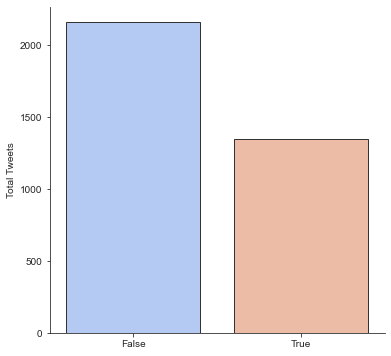

In [52]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(ext_pos_small['is-same'], palette='coolwarm', edgecolor='.2')
ax.set(xlabel='', ylabel='Total Tweets')
sns.despine()

Results are unbalanced - both models seem to predict two different things. I'll need to investigate this further later.

#### How does the number of same predicted categories vary as we increase the probability threshold? ####

         nb_max_prob  svr_max_conf
is-same                           
False       0.207317     -0.237909
True        0.300524      0.153203


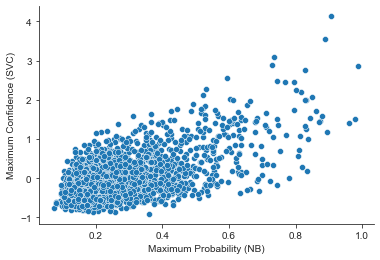

In [61]:
avg_prob = ext_pos_small.groupby('is-same').agg({'nb_max_prob':'mean', 'svr_max_conf':'mean'})
print(avg_prob)

sns.scatterplot(x='nb_max_prob', y='svr_max_conf', data=ext_pos_small)
plt.xlabel('Maximum Probability (NB)')
plt.ylabel('Maximum Confidence (SVC)')
sns.despine()
plt.show()

In [129]:
interval1 = ext_pos_small[(ext_pos_small.nb_max_prob >= 0.3) & (ext_pos_small.svr_max_conf >= 0)]

def check(df, num):
    print(df.iloc[num]['text'])
    print(df.iloc[num]['nb_topic_predict'])
    print(df.iloc[num]['svc_topic_predict'])

### Trial 2: Positive Tweets